In [0]:
#! pip install networkx
#! pip install plotly
#! pip install colorlover

In [0]:
import networkx as nx
import pandas as pd
from collections import Counter
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.graph_objects as go
init_notebook_mode(connected=True)
import random
import colorlover as cl
from IPython.display import HTML
import plotly
import matplotlib.pyplot as plt

In [0]:
df = pd.read_csv("tweets2009-06-0115.csv.zip", sep='\t', compression='zip')

In [0]:
df.head()

,date,user,tweet
0,2009-06-01 21:43:59,burtonator,No Post Title
1,2009-06-01 21:47:23,burtonator,No Post Title
2,2009-06-02 01:15:44,burtonator,No Post Title
3,2009-06-02 05:17:52,burtonator,No Post Title
4,2009-06-02 23:58:25,burtonator,No Post Title


In [0]:
df.shape

(3437690, 3)

# Q1. Choose a hash-tag（#business）

In [0]:
allTweets = df["tweet"].str.cat(sep=' ')
tweetWords = [word.strip(""" ,.:'\";""").lower() for word in allTweets.split()]
hashTags = [word for word in tweetWords if word.startswith("#")]
hashTagsCounter = Counter(hashTags)

In [0]:
hashTagsCounter.most_common(10)#follow-1390

[('#iranelection', 26853),
 ('#followfriday', 16400),
 ('#jobs', 13322),
 ('#iremember', 11057),
 ('#spymaster', 10587),
 ('#ff', 10446),
 ('#squarespace', 9198),
 ('#tcot', 7691),
 ('#fb', 6107),
 ('#cnnfail', 4451)]

In [0]:
businessTag = df[df["tweet"].str.lower().str.contains("#business", na=False)].copy()

In [0]:
businessTag.head()

,date,user,tweet
4254,2009-06-11 17:05:56,india_business,#india #business : Railways may take the priva...
4377,2009-06-11 17:06:16,india_business,#india #business : Who is the media accountabl...
6103,2009-06-11 17:08:28,india_business,#india #business Tech Mahindra not to retrench...
15943,2009-06-11 17:20:13,truebusiness,"California's government risks a financial ""mel..."
15997,2009-06-11 17:20:14,vumax,„FOCUS Media-Guide 2009“ gibt Überblick über d...


In [0]:
def addMentionedColumn(df):
    
    def mentionsList(txt):
        allWords = [word.strip(""" ,.:'\";""").lower() for word in txt.split()]
        allNames = [word.strip("@") for word in allWords if word.startswith("@")]
        uniqueNames = list(set(allNames))
        return allNames
    
    df["mentioned"] = df["tweet"].apply(mentionsList)

In [0]:
addMentionedColumn(businessTag)
businessTag.head()

,date,user,tweet,mentioned
4254,2009-06-11 17:05:56,india_business,#india #business : Railways may take the priva...,[]
4377,2009-06-11 17:06:16,india_business,#india #business : Who is the media accountabl...,[]
6103,2009-06-11 17:08:28,india_business,#india #business Tech Mahindra not to retrench...,[]
15943,2009-06-11 17:20:13,truebusiness,"California's government risks a financial ""mel...",[]
15997,2009-06-11 17:20:14,vumax,„FOCUS Media-Guide 2009“ gibt Überblick über d...,"[yelyahwilliams, spanglishbaby, ranbeuer]"


# Q2. Build a Mention Graph

In [0]:
def mentionGraph(df):
    g = nx.Graph()
    
    for (index, date, user, tweet, mentionedUsers) in df.itertuples():
        for mentionedUser in mentionedUsers:
            if (user in g) and (mentionedUser in g[user]):
                g[user][mentionedUser]["numberMentions"] += 1
            else:
                g.add_edge(user, mentionedUser, numberMentions=1)
    
    return g

In [0]:
businessGraph = mentionGraph(businessTag)

In [0]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [0]:
import random
def addRandomPositions(graph):
    posDict = dict((node,(random.gauss(0,10),random.gauss(0,10))) for node in graph.nodes())
    nx.set_node_attributes(graph, name="pos", values=posDict)

In [0]:
addRandomPositions(businessGraph)

(a) How many nodes and how many edges in your mention graph?

In [0]:
print("# nodes:", len(businessGraph.nodes()))
print("# edges:", len(businessGraph.edges()))

# nodes: 154
# edges: 113


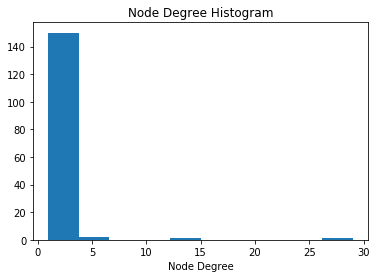

In [0]:
degree = dict(nx.degree(businessGraph)).values()
sorteddegree = sorted(degree)

plt.hist(sorteddegree)
plt.title("Node Degree Histogram")
plt.xlabel("Node Degree")
plt.show()

From the histogram, we can see that the degree distribution is kind of centralized. Most nodes all have very small number of degree. The highest degree is 27. Thus, the group is not connected very strong.

(c) Provide a list of top 5 edges with highest weights (edges are identified be the two nodes they connects, e.g., ⟨node1, node2⟩).

In [0]:
def countweightforedge(graph):
  edge = {}
  for (node1,node2) in graph.edges():
    edgeWidth = graph[node1][node2]['numberMentions']
    edge[(node1,node2)] = edgeWidth
  return edge

In [0]:
business_edge = countweightforedge(businessGraph)

In [0]:
top_5_edges = sorted(business_edge.items(), key=lambda x: -x[1])[:5]
top_5_edges

[(('maynaseric', 'jshe'), 5),
 (('day2daypa', 'kirsty_wilson'), 3),
 (('day2daypa', 'resrec'), 3),
 (('day2daypa', 'narellemais'), 3),
 (('hormonegoddess', 'tomziglar'), 3)]

(d) Provide a visualization of the mention graph in which the edge color reflects its weight (i.e., the number of mentions).

In [0]:
purd = cl.scales['9']['seq']['PuRd']
purd300 = cl.interp(purd, 300)
HTML(cl.to_html(purd300))

In [0]:
def plotNetworkSizeColor(graph):
    maxMention = max(countweightforedge(graph).values())
    minMention = min(countweightforedge(graph).values())

    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        edgeColor = int(299*(edgeWidth-minMention)/(maxMention-minMention))

        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='text',
                mode='lines', 
                text="Edge: %s\Weight: %f" % ((node1,node2), edgeWidth),
                line=scatter.Line(width=edgeWidth ,color=purd300[edgeColor]))
        scatters.append(s)



    for node in graph.nodes():
        xPos, yPos = graph.nodes[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                hoverinfo='none',
                mode='markers', 
                marker=dict(
                    color="#888", 
                    size=2,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [0]:
configure_plotly_browser_state()
plotNetworkSizeColor(businessGraph)

# Q3. Content Analysis

(a) Analyze the most common words in all the tweets with the chosen hash-tag, and provide a basic description of the main themes.

In [0]:
businessTag['tweet'][:20]

4254     #india #business : Railways may take the priva...
4377     #india #business : Who is the media accountabl...
6103     #india #business Tech Mahindra not to retrench...
15943    California's government risks a financial "mel...
15997    „FOCUS Media-Guide 2009“ gibt Überblick über d...
16378    8 Ways to Create Paperless Business Cards http...
24924    Workplace Trends: The End of Cubicle Dwelling:...
80145    #jobs #Business #Dev Manager, Business Develop...
80564    #jobs #Business #Dev Business Development ? Te...
81265    #jobs #Business #Dev Business Development Mana...
81731    #jobs #Business #Dev Manager, Business Develop...
81991    #jobs #Business #Dev BUSINESS DEVELOPMENT REPR...
82193    #jobs #Business #Dev AIRPORT BUSINESS DEVELOPM...
82762    #jobs #Business #Dev Sr Dir Business Developme...
83457    #jobs #Business #Dev Manager, Business Develop...
83835    #jobs #Business #Dev Manager, Business Develop...
84199    #jobs #Business #Dev Capture Manager-DoD,Corpo.

In [0]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from collections import Counter
import re

def getTopK(df, k, value_column='tweet'):
    stop = set(stopwords.words('english'))
    counter = Counter()
    for twt in df[value_column]:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', twt) 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)
    return topk

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
top20 = getTopK(businessTag,20)
top20

[('http', 767),
 ('business', 700),
 ('com', 448),
 ('bit', 205),
 ('tinyurl', 167),
 ('2009', 166),
 ('twitter', 113),
 ('new', 104),
 ('india', 101),
 ('directory', 91),
 ('added', 90),
 ('wefollow', 87),
 ('quickbooks', 77),
 ('fraud', 71),
 ('budurl', 71),
 ('8vuw', 71),
 ('loan', 68),
 ('jobfeedr', 64),
 ('post', 57),
 ('cli', 53)]

The top tweets for hashtag #business are basically related to business development and there is a special location: India. Probably some business groups are dealing business in India.

(b)In the visualization of the mention graph, add hover information for the nodes, describing the 3 most common words for this user. Add any other hover information that may help you understand the social network better.

In [0]:
import operator
def getTopKuser(df, k, label_value, label_column='user', operation=operator.eq, value_column='tweet'):
    stop = set(stopwords.words('english'))
    
    counter = Counter()
    for twt in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', twt) 
                            if word.lower() not in stop and len(word) > 2 and word.isalpha()])
    topk = counter.most_common(k)
    return topk

In [0]:
def plotNetwork_usertop3(graph):
    maxMention = max(countweightforedge(graph).values())
    minMention = min(countweightforedge(graph).values())
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        nodeColor = int(299*(edgeWidth-minMention)/(maxMention-minMention))
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='text',
                text = "Edge: %s\Weight: %f" % ((node1,node2), edgeWidth),
                mode='lines', 
                line=Line(width=edgeWidth ,color=purd300[nodeColor]))
        scatters.append(s)



    for node in graph.nodes():
        xPos, yPos = graph.nodes[node]['pos']
        top3 = getTopKuser(businessTag,k=3,label_value=node)
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                hoverinfo='text',
                text='Node: %s,Top words: %s'%(node,top3),
                mode='markers', 
                marker=dict(
                    color="#888", 
                    size=2,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [0]:
def applyLayout(graph, layoutFunc):
    posDict = layoutFunc(graph) 
    nx.set_node_attributes(graph, name="pos", values=posDict)

In [0]:
businessGraph_usertop3 = businessGraph.copy()
#applyLayout(businessGraph_usertop3, nx.spring_layout)
configure_plotly_browser_state()
plotNetwork_usertop3(businessGraph_usertop3)

/usr/local/lib/python3.6/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [0]:
applyLayout(businessGraph_usertop3, nx.spring_layout)
configure_plotly_browser_state()
plotNetwork_usertop3(businessGraph_usertop3)

/usr/local/lib/python3.6/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




# Q4. Centrality Analysis

(a) Choose two centrality measures and calculate the centrality of the nodes on your graph based on each of the measures.

In [0]:
degree_centrality = nx.degree_centrality(businessGraph)

In [0]:
betweenness_= nx.betweenness_centrality(businessGraph)

(b) Provide a visualization that demonstrates the centrality of each node using a visual property (size, color, etc) for each of the centrality measures.

In [0]:
purd300 = cl.interp(purd,300)
HTML(cl.to_html(purd300))

In [0]:
def plotNetworkCentrality(graph,centrality):
    maxCentr = max(centrality.values())
    minCentr = min(centrality.values())
    
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=scatter.Line(width=edgeWidth ,color='#888'))
        scatters.append(s)



    for node in graph.nodes():
        nodeCentr = centrality[node]
        nodeColor = int(299*(nodeCentr-minCentr)/(maxCentr-minCentr))
        xPos, yPos = graph.nodes[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                text="User: %s\ncCntrality: %.3f" % (node, nodeCentr),
                hoverinfo='text',
                mode='markers', 
                marker=dict(
                    color=purd300[nodeColor], 
                    size=nx.degree(graph,node)*2,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [0]:
businessGraph_1 = businessGraph.copy()
configure_plotly_browser_state()
plotNetworkCentrality(businessGraph_1,betweenness_)

In [0]:
businessGraph_2 = businessGraph.copy()
configure_plotly_browser_state()
plotNetworkCentrality(businessGraph_2,degree_centrality)

(c) Identify the key players in the mentioned graph based on the centrality measures.
1. Are the results similar or different? Explain what can be the reason for the observed similarity or difference.
2. What centrality measure produced a more meaningful interpretation? Why?

The results as we can see from the plots, two measurements provide really similary graphs, both of them pointed out same users. However, the scores are different. More color darkness means higher centrality.

(1) Both measurements pointed out same nodes which have high centrality, meaning the top centrality with these two methods are same, but the scores calculated by each method are different. Also, for that pink node(user: cuteknight16), betweeness method have darker color, meaning it gives higher score to this node.

(2) Betweeness may have more meaning than degree centrality, because it consider the centrality brokerage, like how many pairs of other users have to go through that center node. It can identify the centrality better.

# Q5. Connectivity Patterns

(a) Calculate two or more of the following measures to analyze cliques in your mention graph:
1. Number of maximal cliques in your graph.
2. The graph’s clique number (size of the largest clique in the graph).
3. Number of maximal cliques for each node
4. Size of the largest maximal clique containing each given node.

In [0]:
maxCliques = nx.graph_number_of_cliques(businessGraph)
maxCliques

112

In [0]:
graph_clique_number_ = nx.graph_clique_number(businessGraph)
graph_clique_number_

2

In [0]:
maximal_cliques_for_each_node= nx.number_of_cliques(businessGraph)
maximal_cliques_for_each_node_ = sorted(maximal_cliques_for_each_node.items(), key=lambda x: x[1], reverse=True)
maximal_cliques_for_each_node_

[('hormonegoddess', 29),
 ('cuteknight16', 13),
 ('northavlnews', 6),
 ('themooring', 5),
 ('vumax', 3),
 ('emcerlain', 3),
 ('maynaseric', 3),
 ('day2daypa', 3),
 ('stefanw', 3),
 ('shamhardy', 2),
 ('betterbizideas', 2),
 ('phanatical', 2),
 ('hockeytweeter', 2),
 ('couchburner', 2),
 ('santa_inesita', 2),
 ('nigel_morgan', 2),
 ('', 2),
 ('ceoa', 2),
 ('yodspica', 2),
 ('yelyahwilliams', 1),
 ('spanglishbaby', 1),
 ('ranbeuer', 1),
 ('freshstandard', 1),
 ('sebastianjthe', 1),
 ('_vnl', 1),
 ('bogusky', 1),
 ('buzzedition', 1),
 ('stephcalahan', 1),
 ('dkbird', 1),
 ('cnetnews', 1),
 ('mfgcrunch', 1),
 ('india_business#india', 1),
 ('alextanpr', 1),
 ('chibiryan', 1),
 ('weblittlepieces', 1),
 ('mfp47', 1),
 ('talkabout', 1),
 ('reply', 1),
 ('hanshafner', 1),
 ('gleonhard', 1),
 ('siriuscorp', 1),
 ('codepope', 1),
 ('furststaffing', 1),
 ('hotjobs', 1),
 ('dj_fokis', 1),
 ('adrian_scott', 1),
 ('maddrennan', 1),
 ('mountainjava', 1),
 ('ashevillbrewing', 1),
 ('savoyrestaurant', 1

In [0]:
each_given_node= nx.node_clique_number(businessGraph)
each_given_node_=sorted(each_given_node.items(), key=lambda x: x[1], reverse=True)
each_given_node_

[('vumax', 2),
 ('yelyahwilliams', 2),
 ('spanglishbaby', 2),
 ('ranbeuer', 2),
 ('freshstandard', 2),
 ('sebastianjthe', 2),
 ('_vnl', 2),
 ('bogusky', 2),
 ('buzzedition', 2),
 ('shamhardy', 2),
 ('stephcalahan', 2),
 ('dkbird', 2),
 ('cnetnews', 2),
 ('mfgcrunch', 2),
 ('india_business#india', 2),
 ('alextanpr', 2),
 ('betterbizideas', 2),
 ('chibiryan', 2),
 ('weblittlepieces', 2),
 ('mfp47', 2),
 ('emcerlain', 2),
 ('phanatical', 2),
 ('hockeytweeter', 2),
 ('couchburner', 2),
 ('santa_inesita', 2),
 ('talkabout', 2),
 ('reply', 2),
 ('hanshafner', 2),
 ('gleonhard', 2),
 ('siriuscorp', 2),
 ('codepope', 2),
 ('furststaffing', 2),
 ('hotjobs', 2),
 ('nigel_morgan', 2),
 ('adrian_scott', 2),
 ('maddrennan', 2),
 ('northavlnews', 2),
 ('mountainjava', 2),
 ('ashevillbrewing', 2),
 ('savoyrestaurant', 2),
 ('greathallbar', 2),
 ('maglounge', 2),
 ('craft_gallery', 2),
 ('enjoypeace', 2),
 ('knealemann', 2),
 ('corcoran_group', 2),
 ('timobriennyt', 2),
 ('monicutza03449', 2),
 ('mayn

(b) Provide some insights on the connectivity patterns of your mention graph based on the in- formation calculated in (a). What was the largest clique? How large was it? What else do your clique properties and cliques themselves tell you about the social network?

Based on above 4 questions, the cliques are all small numbers, and look back to centrality analysis, it is make sense that under this hastage, the number of key players are small. This means that user under this hastage are not strongly connected. 

I have total 112 cliques with only two size 1 and 2. And most of them are size 2, size 1 clique takes very small porprotion.

There are only three nodes(users)' max cliques number bigger than 5, and look back to centrality plot, they are the centers.

I have size equal to 2 of the largest maximal clique containing each given node. Meaning that after centrality clustering, components will be 2 for majority. So those groups interact and contact each other is just 2. Thus, #business is a really samll hastags, people under this hashtage is kind isolated to each other.